In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ising import Ising
from IPython import display
import matplotlib as mpl

# parameters for plots
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# critical temperature for ising2d
T_c = 2/np.log(1+np.sqrt(2))

## Equilibrium configuration
We plot the evolution of the system for 3 different temperature
- $T<T_c$
- $T=T_c$
- $T>T_c$

First we use matropolis algorithm and then metropolis in mean field approximation

Befor run the code we plot the magnetization over steps to be sure to use the right number of iterations and reach the equilibrium

In [2]:
test = Ising(50, 50, 0.5, 0, 1)
for _ in range(50000):
    test.metropolis(1)

KeyboardInterrupt: 

In [ ]:
plt.plot(test.mag);

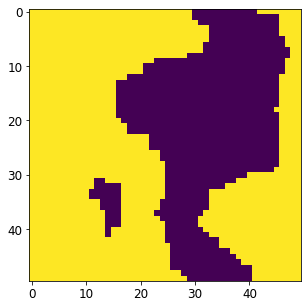

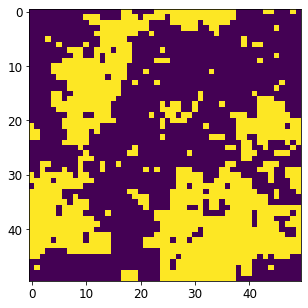

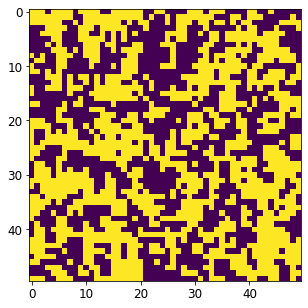

In [2]:
temperatures = [0.5, T_c, 4]

for T in temperatures:
    # create initial random configuration
    ising = Ising(50, 50, T, 0, 1)

    # set up figure, plot first frame
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    # draw the initial configuration,
    # naming the plot "im".
    im = ax.imshow(ising.matrix)

    for t in range(10000):
        # update the system
        ising.metropolis(10)
        # replot every 1000 MC updates
        if t%100==0:
            # update the data of the plot (not the whole figure!)
            im.set_data(ising.matrix)
            # rerender
            display.display(plt.gcf())
            display.clear_output(wait=True)

    # save the final configuration
    fig.savefig(f'./fig/final_state_{T}.pdf', dpi=720)

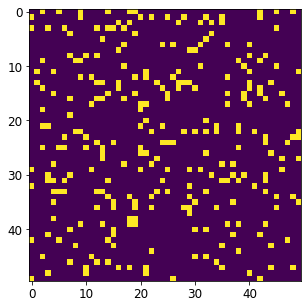

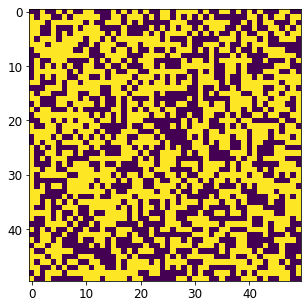

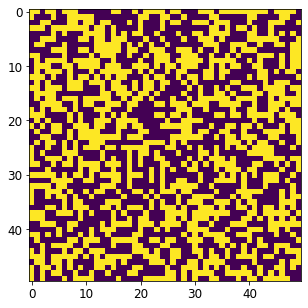

In [5]:
# note: for mf approx the critical temperature is 4 (T_c = J*4/kb)
temperatures = [3, 4, 5]

for T in temperatures:
    # create initial random configuration
    ising = Ising(50, 50, T, 0, 1)

    # set up figure, plot first frame
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    # draw the initial configuration,
    # naming the plot "im".
    im = ax.imshow(ising.matrix)

    for t in range(10000):
        # update the system
        ising.metropolis_mf(10)
        # replot every 1000 MC updates
        if t%100==0:
            # update the data of the plot (not the whole figure!)
            im.set_data(ising.matrix)
            # rerender
            display.display(plt.gcf())
            display.clear_output(wait=True)

    # save the final configuration
    fig.savefig(f'./fig/final_state_mf_{T}.pdf', dpi=720)

## Energy Plot for Wolff algorithm
We now plot the energy as a function of the number of step to see after how many sweeps the system reach the equilibrium

In [10]:
# set system size, temperature
n1 = 100
n2 = 100
T1 = 1.5
T2 = 3.5
T_c = 2/np.log(1+np.sqrt(2))

# run some Wolff sweeps, check if equilibrium
ising_T1 = Ising(n1, n2, T=T1, B=0, J=1)
ising_T2 = Ising(n1, n2, T=T2, B=0, J=1)
ising_T_c = Ising(n1, n2, T=T_c, B=0, J=1)

for i in range(50):
    ising_T1.update_ham()
    ising_T2.update_ham()
    ising_T_c.update_ham()
    ising_T1.SweepWolff()
    ising_T2.SweepWolff()
    ising_T_c.SweepWolff()

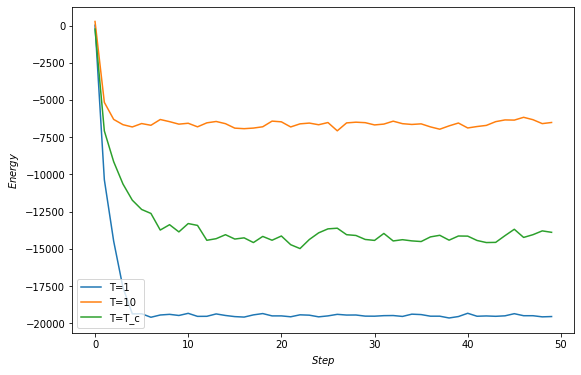

In [11]:
E_T1 = ising_T1.ham
E_T2 = ising_T2.ham
E_T_c = ising_T_c.ham

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(E_T1, label="T=1")
ax.plot(E_T2, label="T=10")
ax.plot(E_T_c, label="T=T_c")

ax.set_xlabel("$Step$")
ax.set_ylabel("$Energy$")
ax.legend(loc=3)

In [4]:
# We create a function to compute couple of value for (magnetization, temperature)
# in order to check phase transition and the correctness of the value of T_c
# computed with the metropolis algorithm
'''
- perché non prendere in input un oggetto Ising? così sostituisci 4 input (n1,n2,B,J)
  con uno solo
- potremmo plottare l'andamento della magnetizzazione prima di eseguire
  così sappiamo dopo quante ripetizioni si stabilizza
'''
def compute_temp_mag(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    magnetizations = np.zeros(n_temperatures)
    for i,t in enumerate (temperatures):
        ising = Ising(n1, n2, t, B, J)
        ising.metropolis(n_repetitions)
        ising.update_mag()
        magnetizations[i] = ising.mag[-1]/n1/n2
        print ( '[',t,',',magnetizations[i],']')
    return(temperatures, magnetizations)

In [2]:
'''
scrivo la stessa funzione ma usando wolff
'''
def compute_mag_wolff(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    magnetizations = np.zeros(n_temperatures)
    for i, t in enumerate (temperatures):
        ising = Ising(n1, n2, t, B, J)
        ising.SweepWolff(n_repetitions)
        ising.update_mag()
        magnetizations[i] = abs(ising.mag[-1])
        #print ( '[',t,',',magnetizations[i],']')
    return(temperatures, magnetizations)

In [3]:
temp, mag = compute_mag_wolff(100,100,0,1,1.5,3.5,80,10)

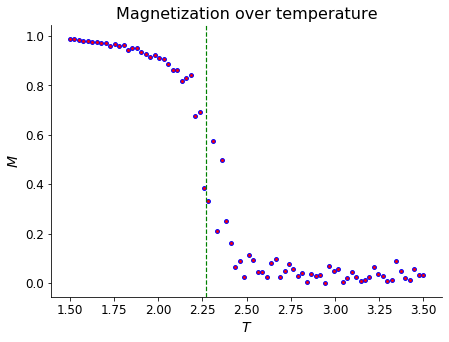

In [4]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.scatter(temp, mag, edgecolors="b", color="r", s=15)
ax.axvline(T_c, c="green", lw=1.2, ls = "dashed")
ax.set_title("Magnetization over temperature")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$");

**We now write a function to plot the evolution of the magnetization in order to find fixed points of the system**

In [130]:
'''
scrivo la stessa funzione ma usando wolff
'''
def mag_evol(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    #magnetizations = [[]] * n_temperatures
    magnetizations = np.zeros((n_temperatures, n_repetitions))
    for i, t in enumerate(temperatures):
        ising = Ising(n1, n2, t, B, J)
        for j in range(n_repetitions):
            ising.update_mag()
            ising.SweepWolff()
            magnetizations[i][j] = (ising.mag[-1])
    return(temperatures, magnetizations)

In [131]:
%%time

temp, mag = mag_evol(250,250,0,1,1.5,3.5,70,10)

CPU times: user 11min 29s, sys: 1.57 s, total: 11min 31s
Wall time: 11min 36s


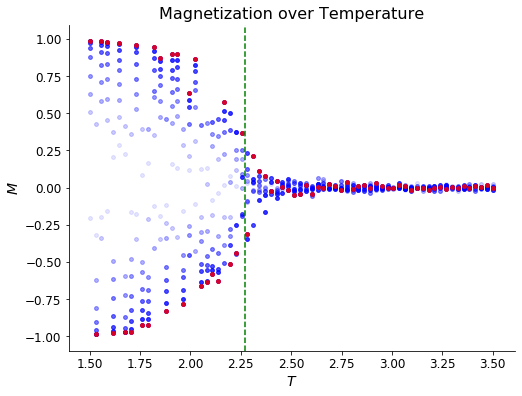

In [132]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(8,6))
for i, t in enumerate(temp):
    temper = [t]*len(mag[i])
    for j in range(len(mag[i])):
        ax.scatter(t, mag[i][j], color="b", s=15, alpha=j/len(mag[i]))
    ax.scatter(t, mag[i][-1], color="r", s=15, alpha=0.8)
ax.axvline(T_c, c="green", lw=1.5, ls = "dashed")
ax.set_title("Magnetization over Temperature")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$");

fig.savefig('./fig/mag_evol_N=250.pdf', dpi=720)

In [74]:
# We create a function to compute couple of value for (magnetization, temperature)
# in order to check phase transition and the correctness of the value of T_c
# computed following the mean field approach
def compute_temp_mag_mf(n1,n2,B,J,t1,t2,n_temperatures,n_repetitions):
    temperatures = np.linspace(t1,t2,n_temperatures)
    magnetizations = np.zeros(n_temperatures)
    for i,t in enumerate (temperatures):
        Ising = Ising(n1, n2, t, B, J)
        Ising.metropolis_mf(n_repetitions)
        Ising.update_mag()
        magnetizations[i] = Ising.mag[-1]
        print ( '[',t,',',magnetizations[i],']')

    return(temperatures, magnetizations)

In [75]:
temp_mf, mag_mf = compute_temp_mag_mf(100,100,0,1,2.5,5,10,500000)


[ 2.5 , 0.8816 ]
[ 2.7777777777777777 , -0.8334 ]
[ 3.0555555555555554 , -0.761 ]
[ 3.3333333333333335 , -0.6536 ]
[ 3.611111111111111 , 0.5322 ]
[ 3.888888888888889 , 0.2824 ]
[ 4.166666666666667 , -0.0264 ]
[ 4.444444444444445 , -0.003 ]
[ 4.722222222222222 , 0.005 ]
[ 5.0 , 0.001 ]


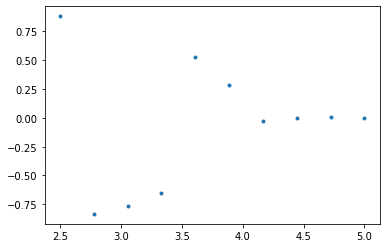

In [76]:
plt.plot(temp_mf,mag_mf,'.')

In [78]:
temp_m1f, mag_mf1 = compute_temp_mag_mf(25,25,0,1,3.5,4.3,10,500000)


[ 3.5 , -0.5872 ]
[ 3.588888888888889 , 0.4656 ]
[ 3.6777777777777776 , -0.5456 ]
[ 3.7666666666666666 , 0.3152 ]
[ 3.8555555555555556 , 0.3376 ]
[ 3.944444444444444 , 0.1296 ]
[ 4.033333333333333 , -0.3568 ]
[ 4.122222222222222 , -0.1808 ]
[ 4.211111111111111 , -0.0752 ]
[ 4.3 , 0.152 ]


In [79]:
temp_mf = np.append(temp_mf,temp_m1f)
mag_mf = np.append(mag_mf,mag_mf1)

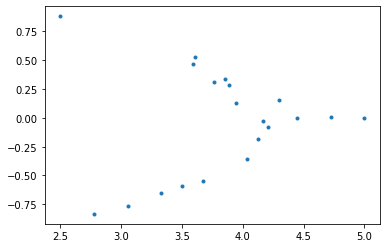

In [80]:
plt.plot(temp_mf,mag_mf,'.')
